## Importing our cleaned dataset from our EDA notebook

In [6]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/hatespeech_detection/binary_hatespeech_cleaned.csv")

In [ ]:
# importing necessary modeling packages
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, f1_score, classification_report, plot_confusion_matrix, plot_roc_curve, roc_auc_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import normalize
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np
import matplotlib.pyplot as plt
import pickle
import joblib
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import XGBClassifier
!pip install datasets
import datasets
import seaborn as sns
import nltk
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Lets define a custom crossvalidation function that we can use with our pipeline object.

In [ ]:
def cross_validation_pip(X_train, y_train, estimator, num_split = 5):
  
  kf = KFold(n_splits= num_split)

  kf.get_n_splits(X_train)
  
  score_val_list = []
  score_train_list = []
  
  for train_index, test_index in kf.split(X):
      # print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      estimator.fit(X_train, y_train)
      y_pred_train = estimator.predict(X_train)
      y_pred_test = estimator.predict(X_test)

      #recall_score(y_test, y_pred_best)
      # now how did we do?
      recall_train = recall_score(y_train, y_pred_train)
      recall_val = recall_score(y_test, y_pred_test)
      score_val_list.append(recall_val)
      score_train_list.append(recall_train)
    
  return {'train': np.mean(score_train_list), 'validation': np.mean(score_val_list)}

## Our baseline model will be a simple logistic regression model

In [ ]:
X = df['text_from_lemma'] # will be using our cleaned lemmatized words
y = df['hatespeech'] # we will be doing a simple binary classifier

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, test_size= .3, stratify= y) # spliting our data and stratafying on y

In [10]:
logistic = Pipeline(steps=[ 
        ('features', TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True)),
        ('classifier', LogisticRegression(solver='saga', n_jobs=-1))
    ])

logistic.fit(X_train, y_train)

y_pred_log = logistic.predict(X_test)

y_pred_log_proba = logistic.predict_proba(X_test)

logistic_score = cross_validation_pip(X_train, y_train, logistic, num_split = 3)

In [11]:
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84     24187
           1       0.80      0.70      0.75     16480

    accuracy                           0.81     40667
   macro avg       0.81      0.79      0.79     40667
weighted avg       0.81      0.81      0.80     40667



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


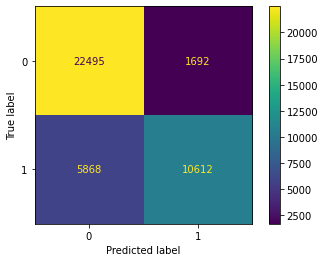

In [12]:
plot_confusion_matrix(logistic, X_test, y_test)

In [ ]:
# search thresholds for imbalanced classification
from numpy import arange
from numpy import argmax
 
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

# keep probabilities for the positive outcome only
probs = y_pred_log_proba[:, 1]

# define thresholds
thresholds = arange(0, 1, 0.001)

# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]

# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

In [ ]:
filename = 'logistic_model.sav'
pickle.dump(logistic, open(filename, 'wb'))

## Running a linear SVM model on our cleaned corpus


In [ ]:
# defining parameter range
param_grid = {'classifier__C': [0.01, 0.1, 1, 10, 100, 1000],
              'classifier__tol': [1e-5, 1e-4, 1e-2, 1, 1e3],
              'vectorizer__max_df': (0.25, 0.5, 0.75),
              'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'vectorizer__norm' : ('l1', 'l2'),
              'vectorizer__sublinear_tf' : (True, False)
              } 

In [ ]:
# define a pipeline for our best model: if you are interested to see how I got here please look at my preliminary notebook
# https://colab.research.google.com/drive/1-IVjUg7nxMCUqeanlInnXHqNn14wAWjS?usp=sharing

pipe  = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LinearSVC(max_iter=10000, random_state=42))
    ]) 

In [ ]:
gs_pipe = RandomizedSearchCV(pipe, param_grid, n_iter=5, scoring= 'recall', n_jobs= -1, refit=True, random_state=42, return_train_score=True)

gs_pipe.fit(X_train, y_train)

best_est = gs_pipe.best_estimator_

In [ ]:
best_est.fit(X_train, y_train)

y_pred_best= best_est.predict(X_test)

y_proba =  best_est.decision_function(X_test)

best_est_score = best_est.score(X_test, y_test)

In [ ]:
cross_validation_pip(X_test, y_test, best_est, num_split = 5)

In [ ]:
print(f"Accuracy score for the model cleaned by this function with grid search parameter-tuning is {best_est_score}")

In [ ]:
plot_confusion_matrix(best_est, X_test, y_test)

In [ ]:
print(f"The Recall Score for the linearSVC is: {recall_score(y_test, y_pred_best)}")

In [ ]:
print(classification_report(y_test, y_pred_best))

## Now its time to finetune our decision threshold for our linear SVM model

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

In [ ]:
# keep probabilities for the positive outcome only
probs = y_proba

# define thresholds
thresholds = arange(0, 1, 0.001)

# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]

# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

In [ ]:
plot_roc_curve(best_est, X_test, y_test)

In [ ]:
roc_auc_score(y_test, y_proba)

In [ ]:
best_est['classifier'].coef_,

In [ ]:
def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

 # create plot

 fig, ax = plt.subplots(1, 1, figsize=(20, 15))

 ax.set_facecolor('black') 

# ax.yaxis.grid(True, which='major')
 ax.yaxis.grid(True, which='major', linestyle='-')
 ax.xaxis.grid(True, linestyle='dashed')

 ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=20)
 
 ax.tick_params(axis='x', which='major', labelsize=20)

 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 
 plt.barh(np.arange(2 * top_features), coef[top_coefficients], color=colors,align = 'edge' )

 feature_names = np.array(feature_names)

 plt.yticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=0, ha= 'right')


 plt.title("Highest Weighted Words for Hate Speech Classification", fontsize=30) 

 plt.show()

cv = best_est['vectorizer']

svm = best_est['classifier']

plot_coefficients(svm, cv.get_feature_names())

In [ ]:
# Get the names of each feature
feature_names = best_est.named_steps["vectorizer"].get_feature_names()

In [ ]:
# Get the coefficients of each feature
coefs = best_est.named_steps["classifier"].coef_.flatten()

In [ ]:

# Zip coefficients and names together and make a DataFrame
zipped = zip(feature_names, coefs)

df_coefs = pd.DataFrame(zipped, columns=["feature", "value"])

# Sort the features by the absolute value of their coefficient
df_coefs["abs_value"] = df_coefs["value"].apply(lambda x: abs(x))

df_coefs["colors"] = df_coefs["value"].apply(lambda x: "yellow" if x > 0 else "red")

df_coefs = df_coefs.sort_values("abs_value", ascending=False)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.barplot(y ="feature",
            x ="value",
            data=df_coefs.head(20),
           palette=df_coefs.head(20)["colors"])


ax.set_facecolor('black') 

# ax.yaxis.grid(True, which='major')
ax.xaxis.grid(True, which='major')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=20)

ax.set_title("Top 20 Indicators for Hate speech", fontsize=30)
ax.set_ylabel("Feature Names", fontsize=22)
ax.set_xlabel("Feature Importance", fontsize=22)

In [ ]:
import pickle

filename = 'linearSVC_model_best.sav'
pickle.dump(best_est, open(filename, 'wb'))

## Now that we have a finetuned model, lets try visualizing the errors our model is making and see if we can learn anything from the models mistakes

In [ ]:
input = X
prediction = y_pred_best
label = y
wrong_predicitons = {}

for input, prediction, label in zip(input, prediction, label):
  if prediction != label:
    wrong_predicitons[input] = [prediction, label]

predicitons = pd.DataFrame.from_dict(wrong_predicitons, orient='index',
  columns=['text', 'prediciton/true_label'] )


## Lets try a tree based model: XGBoost has good results with text classification.

In [ ]:
X = df['text_from_lemma'] # will be using our cleaned lemmatized words

y = df['hatespeech'] # we will be doing a simple binary classifier


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, test_size= .3, stratify= y) # spliting our data and stratafying on y


# fit model no training data

pipe_boost = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer(ngram_range = (1, 2))),
    ('classifier', XGBClassifier())]) 



pipe_boost.fit(X_train, y_train)

# make predictions for test data

y_pred_boost = pipe_boost.predict(X_test)

# evaluate predictions

print(classification_report(y_test, y_pred_boost))

## Lets try doing some hyper parameter tuning for our xgboost model

In [ ]:
params = {'classifier__max_depth': [3,4, 5], 'classifier__learning_rate': [.1, .3, .5],
          'classifier__gamma': [0,5,10], 'classifier__n_estimators': [50,100, 150] }


boost = RandomizedSearchCV(pipe_boost, params, n_iter=5, scoring= 'recall', n_jobs= -1, refit=True, random_state=42, return_train_score=True)

boost.fit(X_train, y_train)

In [ ]:
best_boost = boost.best_estimator_

best_boost.fit(X_train, y_train);

y_pred = best_boost.predict(X_test)

total_preds = best_boost.predict(X_train)

In [ ]:
plot_confusion_matrix(best_boost, X_test, y_test)

In [ ]:
print(classification_report(y_test, y_pred))

## Importing original datasets to append predicition column to

In [ ]:
filename = 'xgboost_model_best.sav'
pickle.dump(best_boost, open(filename, 'wb'))

In [ ]:
import datasets
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')
new_df = dataset['train'].to_pandas()

## Creating a predicition column for our corpus

In [ ]:
new_df.shape

In [ ]:
new_df['hatespeech'] = (new_df['hatespeech']).apply(lambda x: 1 if x > 0 else 0)

In [ ]:
loaded_model = joblib.load('/content/linearSVC_model_best.sav')

In [ ]:
x = new_df[['text']]

y = new_df['hatespeech']

In [ ]:
predicted_score = loaded_model.predict(X)

In [ ]:
predicted_score.shape

In [ ]:
new_df['predicitions'] = predicted_score

In [ ]:
new_df[['text', 'hatespeech', 'predicitions']]

## Creating a profanity list to check how much profanity is in our hatespeech lablled corpus

In [ ]:

# opening the file in read mode
my_file = open("/content/profanity_wordlist.txt", "r")
  
# reading the file
data = my_file.read()
  
# replacing end of line('/n') with ' ' and
# splitting the text it further when '.' is seen.
data_into_list = data.replace('\n', ',').split(".")

# printing the data
print(data_into_list)
my_file.close()

In [ ]:
profanity_list = data_into_list[0].split(',') 

In [ ]:
import re
def pattern_searcher(search_str:str, search_list:str):

    search_obj = re.search(search_list, search_str)

    if search_obj :
        return_str = search_str[search_obj.start(): search_obj.end()]
    else:
        return_str = 'NA'
    return return_str

In [ ]:
pattern = '|'.join(profanity_list)

new_df['profanity_present'] = new_df['text'].apply(lambda x: pattern_searcher(search_str=x, search_list=pattern))